#### Predict the diabetes based on diagnostic measures

In [1]:
pip install scikit-plot

In [2]:
#Let's start with importing necessary libraries

import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skl
sns.set()

import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data = pd.read_csv("diabetes.csv") # Reading the Data
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


we can see there few data for columns Glucose, Insulin, skin thickness, BMI and Blood Pressure which have value as 0. That's not possible, a quick search to see that one cannot have 0 values for these.
Let's deal with that. we can either remove such data or simply replace it with their respective mean values.
Let's do the latter.

In [5]:
# replacing zero values with the mean of the column
data['BMI'] = data['BMI'].replace(0,data['BMI'].mean())
data['BloodPressure'] = data['BloodPressure'].replace(0,data['BloodPressure'].mean())
data['Glucose'] = data['Glucose'].replace(0,data['Glucose'].mean())
data['Insulin'] = data['Insulin'].replace(0,data['Insulin'].mean())
data['SkinThickness'] = data['SkinThickness'].replace(0,data['SkinThickness'].mean())

Box Plot used to see Outliers in dataset

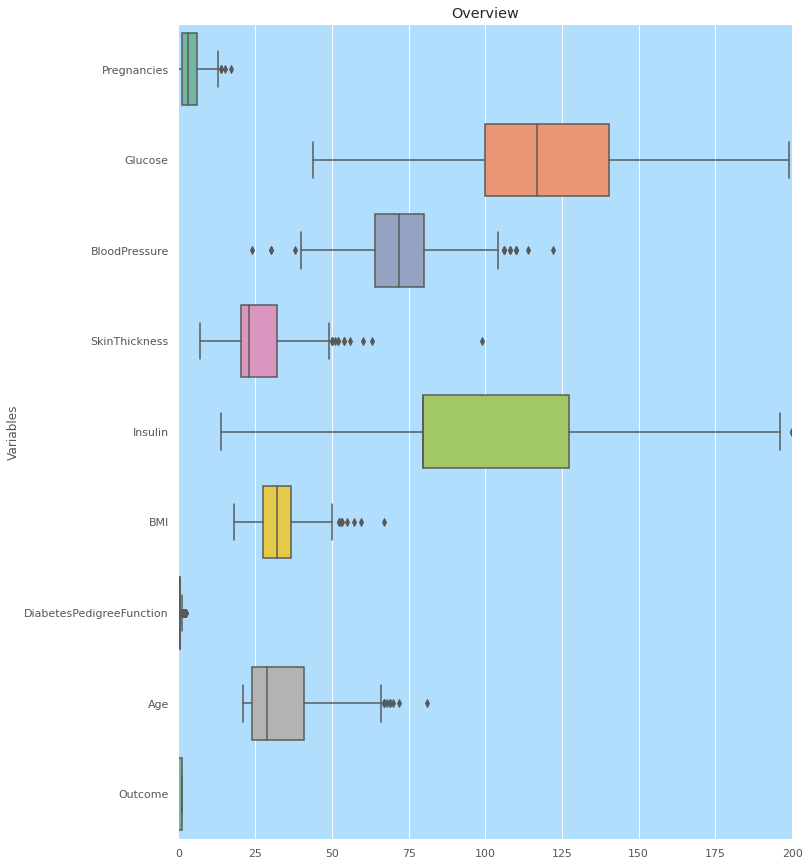

In [6]:
plt.style.use('ggplot') 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#B1DEFD')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview")
ax = sns.boxplot(data = data, 
  orient = 'h', 
  palette = 'Set2',)

Remove Outliers

In [7]:
def Remove_Outlier (col):
    Q1,Q3 = np.percentile (col,[25,75])
    
    IQR= Q3-Q1
    
    upper_range =  Q3+(IQR*1.5)
    
    lower_range =  Q1-(IQR*1.5)
    
    return upper_range,lower_range


for i in data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]:
    ur,lr = Remove_Outlier(data[i])
    data[i]= np.where(data[i]>ur,ur,data[i])
    data[i]= np.where(data[i]<lr,lr,data[i])


Box Plot after Remove Otliers

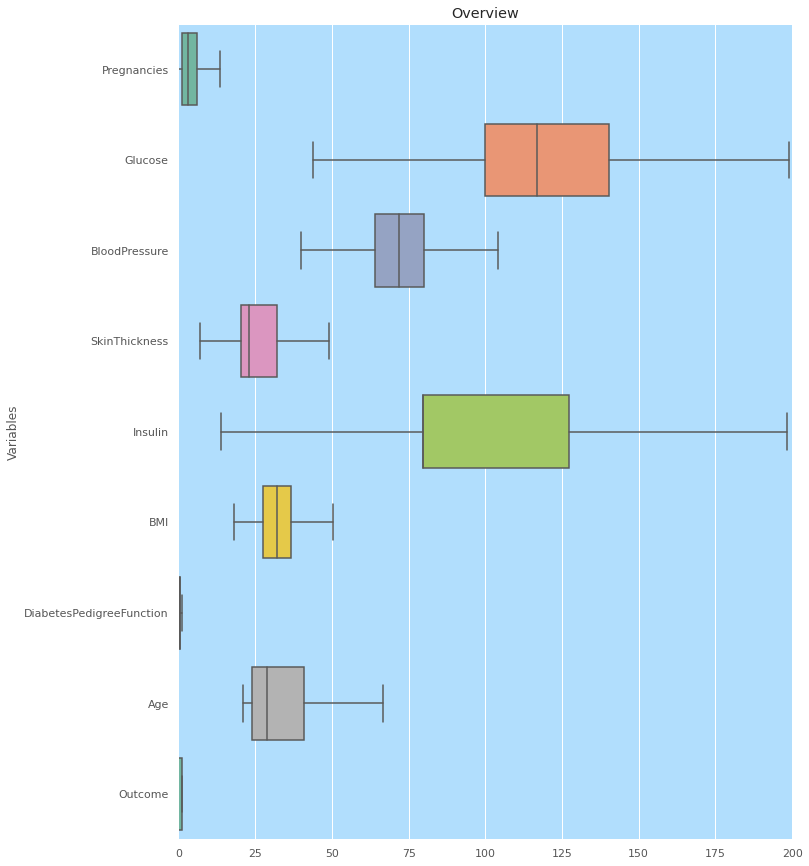

In [8]:
plt.style.use('ggplot') 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#B1DEFD')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview")
ax = sns.boxplot(data = data, 
  orient = 'h', 
  palette = 'Set2',)

Column names are : ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


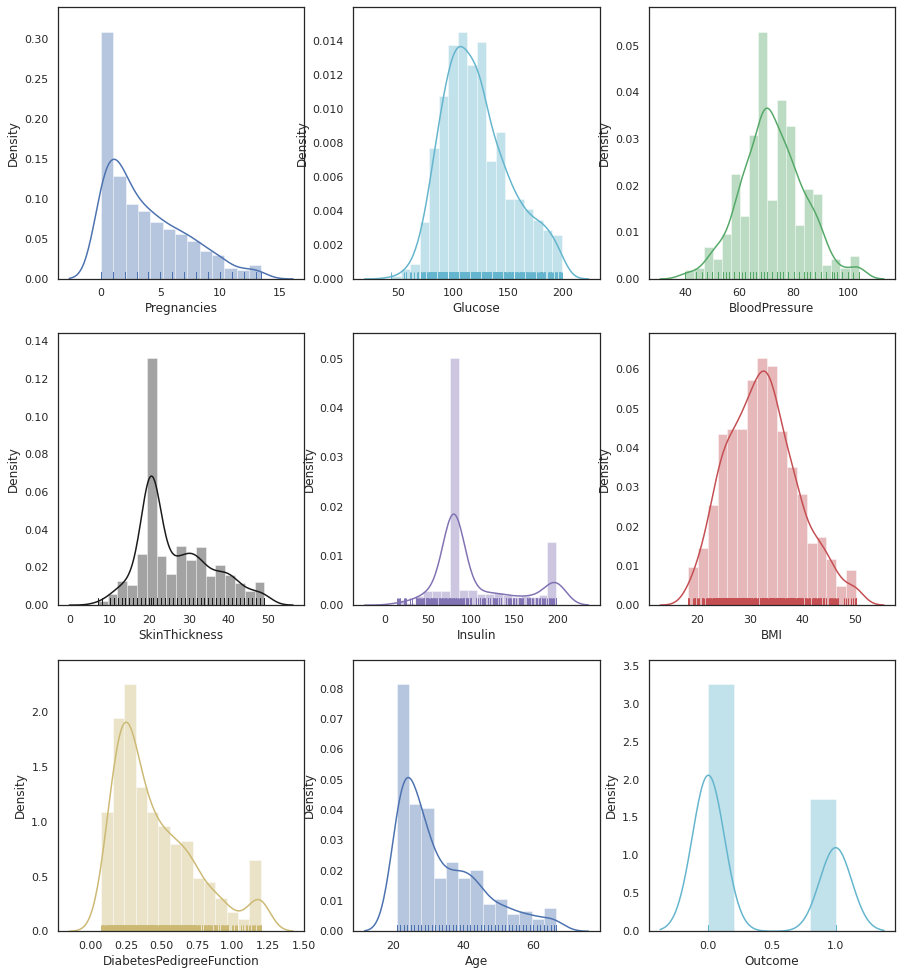

In [9]:
# Add all column names to a list and show data distribution
columns=data.columns
columns=list(columns)
#columns.pop()
print("Column names are :",columns)

#Graphs to be plotted with these colors
colours=['b','c','g','k','m','r','y','b','c']
sns.set(rc={'figure.figsize':(15,17)})
sns.set_style(style='white')
for i in range(len(columns)):
    
    plt.subplot(3,3,i+1)
    sns.distplot(data[columns[i]], hist=True, rug=True, color=colours[i])

In [10]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title('Correlation Matrix for diabetes', fontsize=15)
    plt.show()

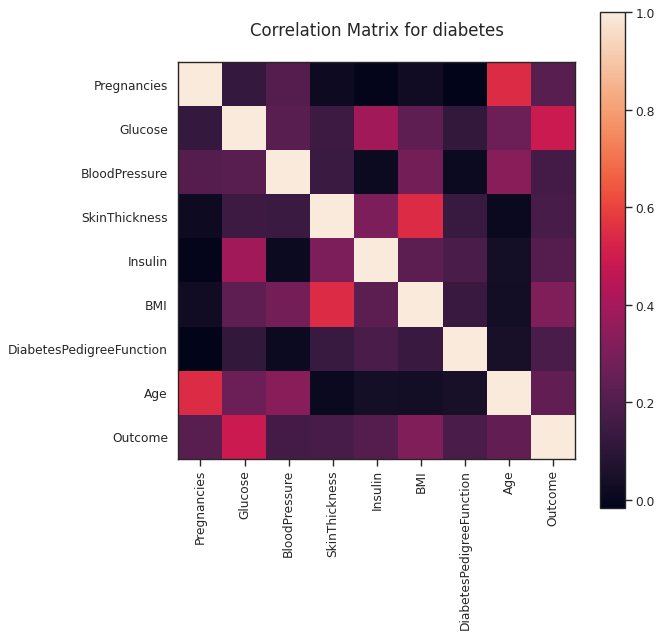

In [11]:
plotCorrelationMatrix(data, 8)

In [12]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [13]:
X = data.drop(columns = ['Outcome'])
y = data['Outcome']

In [14]:
# we need to scale our data as well

scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

In [15]:
# This is how our data looks now after scaling.
X_scaled

array([[ 0.64714967,  0.86527574, -0.01931497, ...,  0.18174861,
         0.58892732,  1.44569096],
       [-0.84896998, -1.20598931, -0.53173732, ..., -0.86878338,
        -0.37810147, -0.189304  ],
       [ 1.24559754,  2.01597855, -0.70254478, ..., -1.36403417,
         0.74659506, -0.10325164],
       ...,
       [ 0.34792574, -0.02240928, -0.01931497, ..., -0.92881378,
        -0.74949659, -0.27535637],
       [-0.84896998,  0.14197684, -1.04415968, ..., -0.34351738,
        -0.38510892,  1.18753386],
       [-0.84896998, -0.94297153, -0.19012242, ..., -0.29849459,
        -0.50423566, -0.87772293]])

In [16]:
# now we will check for multicollinearity using VIF(Variance Inflation factor)
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"] = X.columns

#let's check the values
vif

,vif,Features
0,1.441035,Pregnancies
1,1.339859,Glucose
2,1.255376,BloodPressure
3,1.511652,SkinThickness
4,1.315979,Insulin
5,1.576817,BMI
6,1.052224,DiabetesPedigreeFunction
7,1.628047,Age


All the VIF values are less than 5 and are very low. That means no multicollinearity. 
Now, we can go ahead with fitting our data to the model.
Before that, let's split our data in test and training set.

Train and Test data split

In [17]:
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y, test_size= 0.2, random_state = 35)

###Modelling

Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [19]:
model.fit(x_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [20]:
y_pred = model.predict(x_test)

In [21]:
print(accuracy_score(y_test, y_pred))

0.7402597402597403


In [22]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat

array([[82, 18],
       [22, 32]])

In [23]:
true_positive = conf_mat[0][0]
false_positive = conf_mat[0][1]
false_negative = conf_mat[1][0]
true_negative = conf_mat[1][1]

In [24]:
# Breaking down the formula for Accuracy
Accuracy = (true_positive + true_negative) / (true_positive +false_positive + false_negative + true_negative)
Accuracy

0.7402597402597403

In [25]:
# Precison
Precision = true_positive/(true_positive+false_positive)
Precision

0.82

In [26]:
# Recall
Recall = true_positive/(true_positive+false_negative)
Recall

0.7884615384615384

In [27]:
# F1 Score
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
F1_Score

0.803921568627451

In [28]:
# Area Under Curve
auc = roc_auc_score(y_test, y_pred)
auc

0.7062962962962963

In [29]:
#Printing classification report for Naive Bayes claassifier
from sklearn import metrics
print('Classification Report_test','\n',metrics.classification_report(y_test, y_pred))

Classification Report_test 
               precision    recall  f1-score   support

           0       0.79      0.82      0.80       100
           1       0.64      0.59      0.62        54

    accuracy                           0.74       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.74      0.74      0.74       154



So far we have been doing  grid search to maximise the accuracy of our model.
 Here, we’ll follow a different approach. We’ll create two models, one with Logistic regression and other with Naïve Bayes and we’ll compare the AUC. The algorithm having a better AUC shall be considered for production.

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

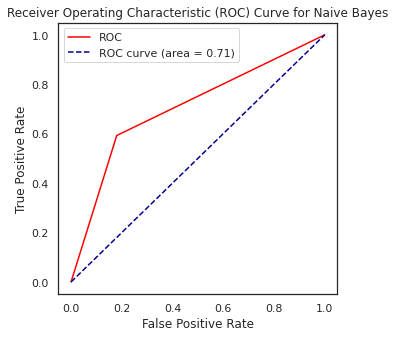

In [31]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Naive Bayes')
plt.legend()
plt.show()

Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

log_reg.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
y_pred_logistic = log_reg.predict(x_test)

In [34]:
accuracy_logistic = accuracy_score(y_test,y_pred_logistic)
accuracy_logistic

0.7467532467532467

In [35]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test,y_pred_logistic)
conf_mat

array([[89, 11],
       [28, 26]])

In [36]:
# Area Under Curve
auc_logistic = roc_auc_score(y_test, y_pred_logistic)
auc_logistic

0.6857407407407407

In [37]:
# ROC
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_pred_logistic)

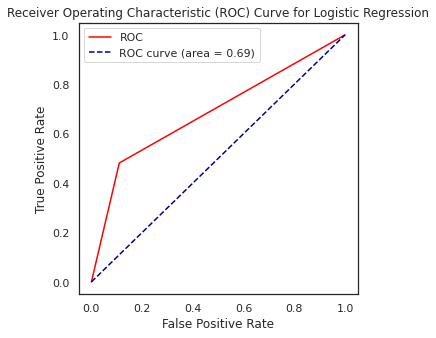

In [38]:
plt.figure(figsize=(5,5))
plt.plot(fpr_logistic, tpr_logistic, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc_logistic)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend()
plt.show()

In [39]:
from sklearn.metrics  import roc_auc_score

In [40]:
auc_naive=roc_auc_score(y_test,y_pred)
auc_naive

0.7062962962962963

In [41]:
auc_logistic=roc_auc_score(y_test,y_pred_logistic)
auc_logistic

0.6857407407407407

 Here, follow a different approach,created two models, one with Logistic regression and other with Naïve Bayes and compare the AUC. The algorithm having a better AUC shall be considered for create model

Here, you can see that the AUC for Naïve Bayes is more. So, we can take that as our model.